# Feature engineering

## Setup

In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm # DO NOT REMOVE

from typing import List

%matplotlib inline

## Run setup


In [4]:
CSV_PATH = "../data/gym_members_exercise_tracking.csv"
df = pd.read_csv(CSV_PATH)

In [5]:
from libs.setup import Run

run = Run(Path.joinpath(Path.cwd().parent, "runs")).initialize()

run.add_raw(df, filename="gym_members_exercise_tracking")

14:26:11 - INFO - Data saved to c:\Users\drwni\Desktop\MEINF\AI\WP_01\runs\2024-12-15_14-26-11\data\raw\gym_members_exercise_tracking.csv


WindowsPath('c:/Users/drwni/Desktop/MEINF/AI/WP_01/runs/2024-12-15_14-26-11/data/raw/gym_members_exercise_tracking.csv')

## Feature creation

In [6]:
# Show missing values
_null = df.isnull().sum()

print(_null[_null > 0] if any(_null) else "No missing values")

No missing values


There are no missing values in the dataset, so we won't have to create any missing imputation.

## Feature encoding

In [7]:
from sklearn.preprocessing import OneHotEncoder

_encoder = OneHotEncoder()
_encoded_categorical = pd.DataFrame(
    _encoder.fit_transform(df.select_dtypes(include=['object'])).toarray(), 
    columns=_encoder.get_feature_names_out(df.select_dtypes(include=['object']).columns),
)

encoded_df = df.drop(columns=df.select_dtypes(include=['object']).columns)
encoded_df = pd.concat([encoded_df, _encoded_categorical], axis=1)
encoded_df.head()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Gender_Male,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
0,56,88.3,1.71,180,157,60,1.69,1313.0,12.6,3.5,4,3,30.20,0.0,1.0,0.0,0.0,0.0,1.0
1,46,74.9,1.53,179,151,66,1.30,883.0,33.9,2.1,4,2,32.00,1.0,0.0,0.0,1.0,0.0,0.0
2,32,68.1,1.66,167,122,54,1.11,677.0,33.4,2.3,4,2,24.71,1.0,0.0,1.0,0.0,0.0,0.0
3,25,53.2,1.70,190,164,56,0.59,532.0,28.8,2.1,3,1,18.41,0.0,1.0,0.0,0.0,1.0,0.0
4,38,46.1,1.79,188,158,68,0.64,556.0,29.2,2.8,3,1,14.39,0.0,1.0,0.0,0.0,1.0,0.0


## Feature selection

 We will check each feature's importance using an estimator with ```feature_importance```, for example ```ExtraTreesRegressor``` and ```Lasso```

In [8]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

TARGET = "Calories_Burned"

X = encoded_df.drop(columns=[TARGET])
y = encoded_df[TARGET]

In [9]:
# Using the parameters from the scikit-learn documentation
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(),
    "Lasso": Lasso(alpha=0.1),
}

X_data = {}

for name, model in models.items():
    selector = SelectFromModel(model).fit(X, y)
    _support = selector.get_support()
    _features = X.columns[_support]
    X_data[name] = X[_features]
    print(f"Selected features from {name}: {_features}")

Selected features from ExtraTreesRegressor: Index(['Avg_BPM', 'Session_Duration (hours)', 'Experience_Level'], dtype='object')
Selected features from Lasso: Index(['Age', 'Weight (kg)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
       'Session_Duration (hours)', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Gender_Female', 'Workout_Type_Cardio', 'Workout_Type_Yoga'],
      dtype='object')


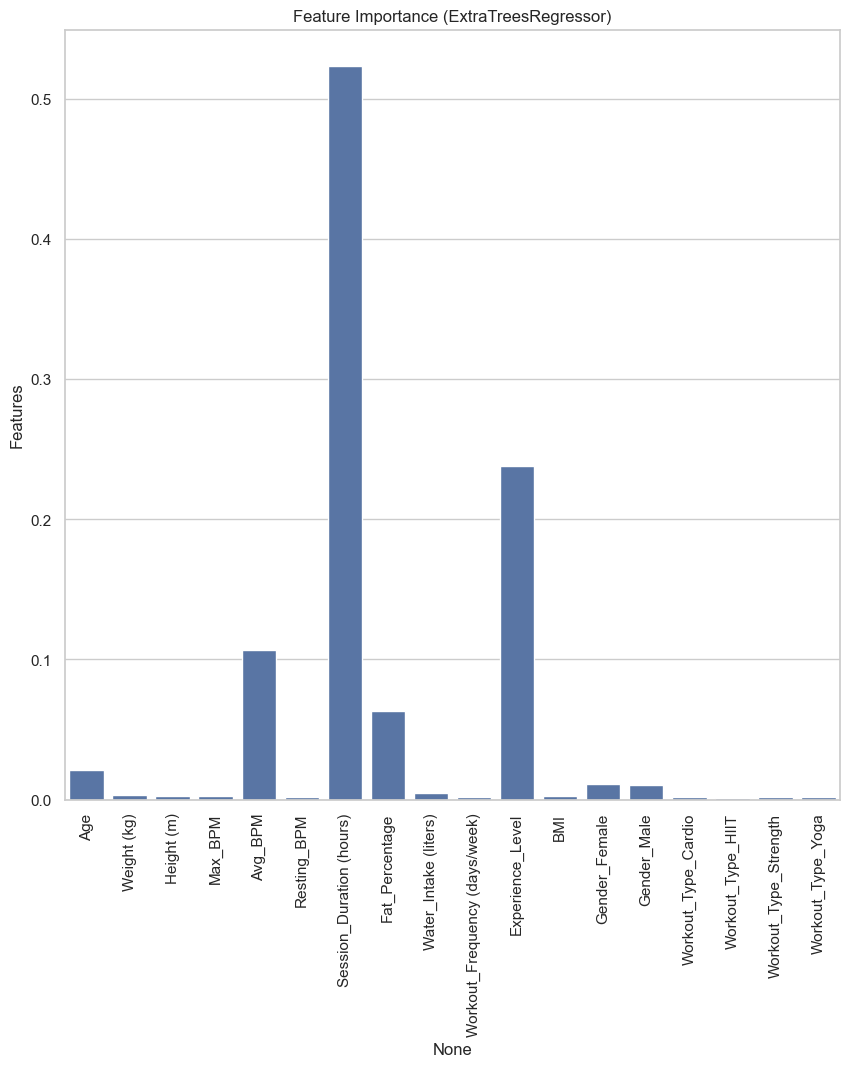

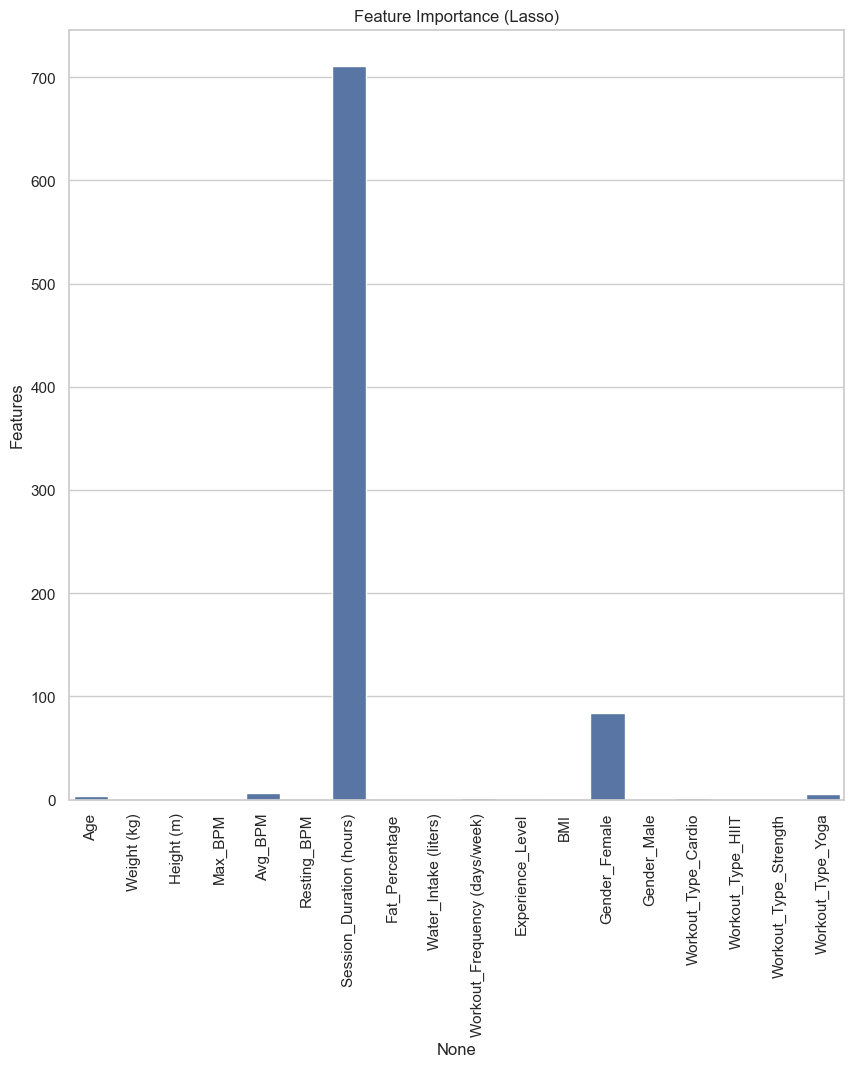

In [12]:
# Feature Importance plots
for name, model in models.items():
    model.fit(X, y)
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 10))
    sns.barplot(y=model.feature_importances_ if name == "ExtraTreesRegressor" else np.abs(model.coef_), x=X.columns)
    plt.title(f"Feature Importance ({name})")
    plt.ylabel("Features")
    plt.xticks(rotation=90)
    plt.show()

In [13]:
X_data["ExtraTreesRegressor"].head()

,Avg_BPM,Session_Duration (hours),Experience_Level
0,157,1.69,3
1,151,1.30,2
2,122,1.11,2
3,164,0.59,1
4,158,0.64,1


In [14]:
X_data["Lasso"].head()

,Age,Weight (kg),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Workout_Type_Cardio,Workout_Type_Yoga
0,56,88.3,180,157,60,1.69,12.6,3.5,4,3,30.20,0.0,0.0,1.0
1,46,74.9,179,151,66,1.30,33.9,2.1,4,2,32.00,1.0,0.0,0.0
2,32,68.1,167,122,54,1.11,33.4,2.3,4,2,24.71,1.0,1.0,0.0
3,25,53.2,190,164,56,0.59,28.8,2.1,3,1,18.41,0.0,0.0,0.0
4,38,46.1,188,158,68,0.64,29.2,2.8,3,1,14.39,0.0,0.0,0.0
